In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
# import missingno as msno
import matplotlib.pyplot as plt
from scipy import stats, fft
from datetime import timedelta



In [ ]:
path = r"dataset4-1.csv"
df = pd.read_csv(path)
df.head(4)

,cow,date,hour,IN_ALLEYS,REST,EAT,ACTIVITY_LEVEL,oestrus,calving,lameness,mastitis,LPS,acidosis,other_disease,accidents,disturbance,mixing,management_changes,OK
0,35687,2014-12-01,1,268.600,3288.426,42.973,-695.31332,0,0,0,0,NaN,NaN,0,0,0,0,0,1
1,35687,2014-12-01,2,169.599,3430.400,0.000,-761.85616,0,0,0,0,NaN,NaN,0,0,0,0,0,1
2,35687,2014-12-01,3,35.068,3564.931,0.000,-814.32325,0,0,0,0,NaN,NaN,0,0,0,0,0,1
3,35687,2014-12-01,4,0.000,3599.999,0.000,-827.99977,0,0,0,0,NaN,NaN,0,0,0,0,0,1


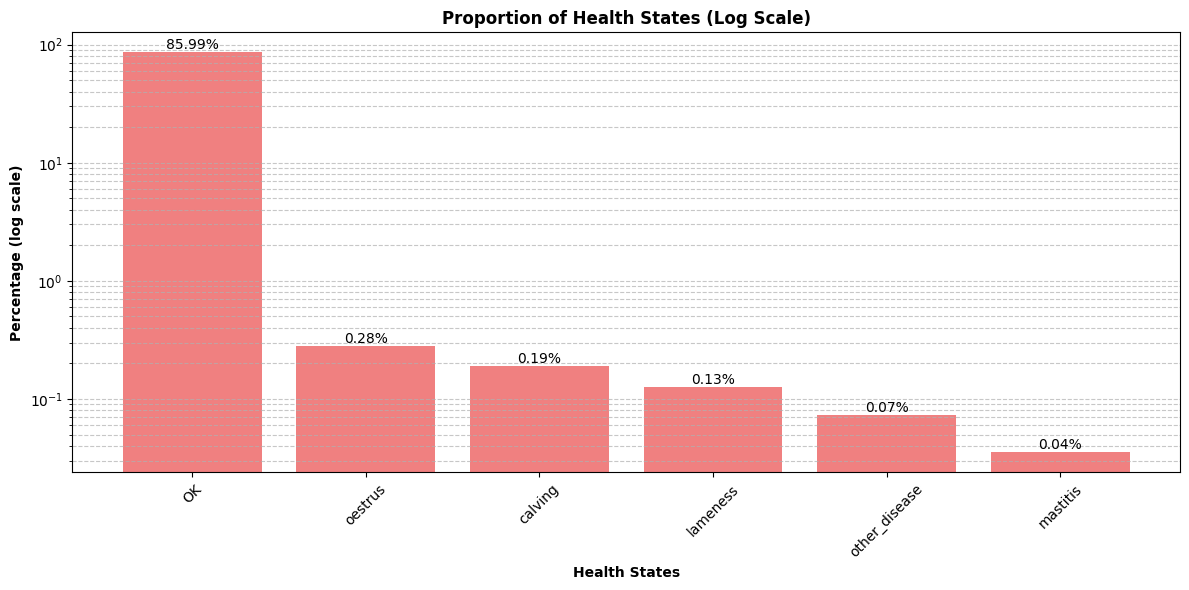

In [ ]:
health_states = ['oestrus', 'calving', 'lameness', 'mastitis', 'other_disease', 'OK']

df_health = df[health_states]
health_counts = df_health.sum().sort_values(ascending=False)
total = len(df)
health_percent = (health_counts / total) * 100

safe_health_percent = health_percent.copy()
safe_health_percent[safe_health_percent == 0] = 0.01

plt.figure(figsize=(12, 6))
bars = plt.bar(safe_health_percent.index, safe_health_percent.values, color='lightcoral')

for i, bar in enumerate(bars):
    original = health_percent.values[i]
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
             f'{original:.2f}%', ha='center', va='bottom')

plt.yscale('log')
plt.title('Proportion of Health States (Log Scale)', fontweight='bold')
plt.xlabel('Health States', fontweight='bold')
plt.ylabel('Percentage (log scale)', fontweight='bold')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7, which='both')
plt.tight_layout()
plt.show()

In [ ]:
df['date'] = pd.to_datetime(df['date'])

obs_counts = df.groupby(['cow', 'date']).size().reset_index(name='hour_count')

missing_obs = obs_counts[obs_counts['hour_count'] < 24]

# plt.figure(figsize=(12, 6))
# missing_obs.groupby('cow')['hour_count'].apply(lambda x: (24 - x).sum()).sort_values(ascending=False).plot(kind='bar')
# plt.title("Total Missing Hours per Cow (only cows with missing 24h records)")
# plt.xlabel("Cow ID")
# plt.ylabel("Total Missing Hours")
# plt.tight_layout()
# plt.show()

Investigate the correlation between the "OK" label and other health states.


Check if, in the dataset, when a cow is labeled as OK, there is any other health label equal to 1.


In [ ]:
health_labels = [
    'oestrus', 'calving', 'lameness', 'mastitis', 'other_disease', 'accidents', 'disturbance',
    'mixing', 'management_changes'
]

correlations = df[health_labels + ['OK']].corr()['OK'].drop('OK')

ok_and_pathology_overlap = df[(df['OK'] == 1) & (df[health_labels].sum(axis=1) > 0)]


print(correlations)
print(ok_and_pathology_overlap)


oestrus              -0.063784
calving                    NaN
lameness             -0.096693
mastitis             -0.041706
other_disease        -0.068208
accidents                  NaN
disturbance          -0.804610
mixing                     NaN
management_changes   -0.010908
Name: OK, dtype: float64
        cow       date  hour  IN_ALLEYS      REST       EAT  ACTIVITY_LEVEL  \
600    7163 2015-03-27     1    114.055  3485.944     0.000      -783.51832   
601    7163 2015-03-27     2     41.395  3558.604     0.000      -811.85572   
602    7163 2015-03-27     3      0.000  3599.999     0.000      -827.99977   
603    7163 2015-03-27     4     52.625  3547.374     0.000      -807.47602   
604    7163 2015-03-27     5     78.736  3521.263     0.000      -797.29273   
...     ...        ...   ...        ...       ...       ...             ...   
38058  2603 2015-03-30    20    405.008  3166.022    28.969      -651.21680   
38059  2603 2015-03-30    21    476.575  1658.526  1337.185     

Manual check

In [ ]:
# Liste des colonnes représentant les états de santé
health_labels = [
    'oestrus', 'calving', 'lameness', 'mastitis', 'other_disease', 'accidents',
]

# Filtrer les lignes où OK == 1 et au moins un état de santé est aussi à 1
violations = df[(df['OK'] == 1) & (df[health_labels].sum(axis=1) > 0)]

# Vérification et affichage
if violations.empty:
    print("✅ Aucun cas trouvé où OK == 1 et un état de santé est aussi à 1. Tout est cohérent.")
else:
    print("⚠️ Des cas incohérents ont été trouvés ! Voici les lignes concernées :")
    print(violations)


✅ Aucun cas trouvé où OK == 1 et un état de santé est aussi à 1. Tout est cohérent.


## . Data Preprocessing


Step 2: Perform another cleaning by keeping only records with more that 18 samples


In [ ]:
df_cleaned =df.copy()
df_cleaned['date'] = pd.to_datetime(df_cleaned['date'])

hourly_counts = df_cleaned.groupby(['cow', 'date']).size().reset_index(name='hour_count')


In [ ]:
# Identify 24h records by observation count

records_more_than_18_obs = hourly_counts[hourly_counts['hour_count'] > 18]
records_12_to_18_obs = hourly_counts[(hourly_counts['hour_count'] >= 12) & (hourly_counts['hour_count'] < 18)]
records_less_than_12_obs = hourly_counts[hourly_counts['hour_count'] < 12]

# Merge to filter full rows from original dataframe
df_more_than_18_obs = df_cleaned.merge(records_more_than_18_obs[['cow', 'date']], on=['cow', 'date'])
df_12_to_18_obs = df_cleaned.merge(records_12_to_18_obs[['cow', 'date']], on=['cow', 'date'])
df_less_than_12_obs = df_cleaned.merge(records_less_than_12_obs[['cow', 'date']], on=['cow', 'date'])

# Drop the records with less than 12 observations from the main dataset
df_filtered = df_cleaned[~df_cleaned.set_index(['cow', 'date']).index.isin(df_less_than_12_obs.set_index(['cow', 'date']).index)]

# Print dataset shapes
print("Original dataset shape:", df.shape)
print("After filtering (<12 obs removed):", df_filtered.shape)
print("Deleted rows (<12 obs):", df_less_than_12_obs.shape)
print("Filtered dataset (>18 obs):", df_more_than_18_obs.shape)
print("Filtered dataset (12–18 obs):", df_12_to_18_obs.shape)

Original dataset shape: (40247, 19)
After filtering (<12 obs removed): (40247, 19)
Deleted rows (<12 obs): (0, 19)
Filtered dataset (>18 obs): (40247, 19)
Filtered dataset (12–18 obs): (0, 19)


In [ ]:
# Save datasets
df_more_than_18_obs.to_csv(r"filtered_dataset_more_than_18_obs.csv", index=False)

In [ ]:
# Count number of unique (cow, date) pairs and unique cows for df_more_than_18_days
num_days_more_than_18 = df_more_than_18_obs[['cow', 'date']].drop_duplicates().shape[0]
num_cows_more_than_18 = df_more_than_18_obs['cow'].nunique()

# Count number of unique (cow, date) pairs and unique cows for df_12_to_18_days
num_days_12_to_18 = df_12_to_18_obs[['cow', 'date']].drop_duplicates().shape[0]
num_cows_12_to_18 = df_12_to_18_obs['cow'].nunique()

# Print results
print("More than 18 days:")
print(f"Number of unique days: {num_days_more_than_18}")
print(f"Number of unique cows: {num_cows_more_than_18}")

print("\n12 to 18 days:")
print(f"Number of unique days: {num_days_12_to_18}")
print(f"Number of unique cows: {num_cows_12_to_18}")


More than 18 days:
Number of unique days: 1677
Number of unique cows: 28

12 to 18 days:
Number of unique days: 0
Number of unique cows: 0


Total gaps found: 2


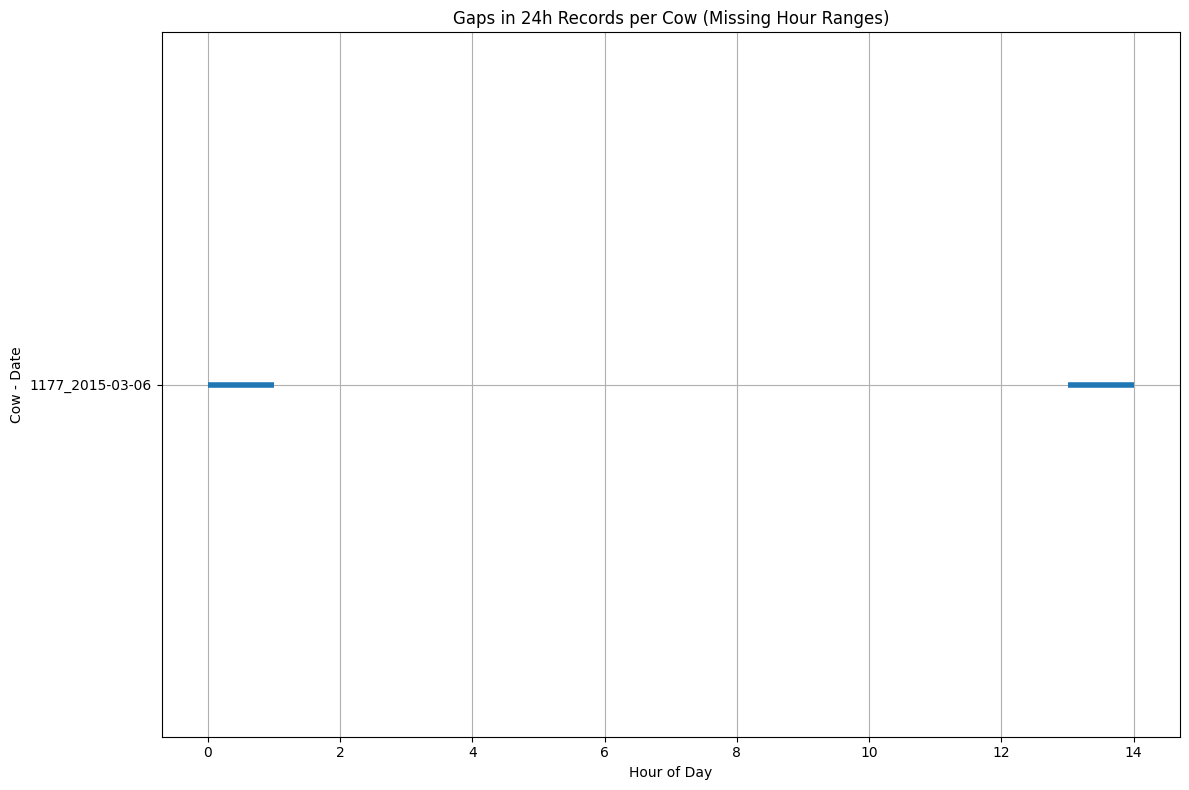

In [ ]:
df = pd.read_csv(r"filtered_dataset_more_than_18_obs.csv")


# Ensure correct types
df['hour'] = df['hour'].astype(int)
df['date'] = pd.to_datetime(df['date'])

# Identify full range of hours
full_hours = list(range(24))

# Keep only cows that have missing hours
hour_counts = df.groupby(['cow', 'date'])['hour'].nunique().reset_index(name='hour_count')
incomplete_days = hour_counts[hour_counts['hour_count'] < 24]
df_incomplete = df.merge(incomplete_days[['cow', 'date']], on=['cow', 'date'])

# Build gap data
gap_data = []
for (cow, date), group in df_incomplete.groupby(['cow', 'date']):
    observed_hours = sorted(group['hour'].unique())
    missing_hours = sorted(set(full_hours) - set(observed_hours))
    gaps = []
    if missing_hours:
        start = missing_hours[0]
        for i in range(1, len(missing_hours)):
            if missing_hours[i] != missing_hours[i-1] + 1:
                gaps.append((start, missing_hours[i-1]))
                start = missing_hours[i]
        gaps.append((start, missing_hours[-1]))
        for g_start, g_end in gaps:
            gap_data.append({
                'cow': cow,
                'date': date,
                'start_hour': g_start,
                'end_hour': g_end
            })

gap_df = pd.DataFrame(gap_data)

# Plot gaps
print(f"Total gaps found: {len(gap_df)}")
if len(gap_df):
    plt.figure(figsize=(12, 8))
    for cow in gap_df['cow'].unique():
        cow_data = gap_df[gap_df['cow'] == cow]
        for i, row in cow_data.iterrows():
            plt.hlines(y=f"{row['cow']}_{row['date'].date()}", xmin=row['start_hour'], xmax=row['end_hour']+1, linewidth=4)

    plt.xlabel('Hour of Day')
    plt.ylabel('Cow - Date')
    plt.title('Gaps in 24h Records per Cow (Missing Hour Ranges)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
df.head(24)

,cow,date,hour,IN_ALLEYS,REST,EAT,ACTIVITY_LEVEL,oestrus,calving,lameness,mastitis,LPS,acidosis,other_disease,accidents,disturbance,mixing,management_changes,OK
0,7163,2015-03-02,1,185.517,3414.482,0.000,-755.64814,0,0,0,0,NaN,0,0,0,1,0,0,0
1,7163,2015-03-02,2,0.000,3599.999,0.000,-827.99977,0,0,0,0,NaN,0,0,0,1,0,0,0
2,7163,2015-03-02,3,10.661,3589.338,0.000,-823.84198,0,0,0,0,NaN,0,0,0,1,0,0,0
3,7163,2015-03-02,4,43.800,3556.199,0.000,-810.91777,0,0,0,0,NaN,0,0,0,1,0,0,0
4,7163,2015-03-02,5,17.167,3582.832,0.000,-821.30464,0,0,0,0,NaN,0,0,0,1,0,0,0
5,7163,2015-03-02,6,1313.335,509.689,1776.975,839.23463,0,0,0,0,NaN,0,0,0,1,0,0,0
6,7163,2015-03-02,7,153.857,0.000,3446.142,1471.99676,0,0,0,0,NaN,0,0,0,1,0,0,0
7,7163,2015-03-02,8,450.335,365.718,2780.390,1155.70226,0,0,0,0,NaN,0,0,0,1,0,0,0
8,7163,2015-03-02,9,2627.864,195.151,776.984,701.90679,0,0,0,0,NaN,0,0,0,1,0,0,0
9,7163,2015-03-02,10,1222.628,273.509,2099.134,1014.34969,0,0,0,0,NaN,0,0,0,1,0,0,0


Step 1: Perform initial cleaning by keeping only physiological classes:


Retain: mastitis, lameness, oestrus, calving, other_diseases, OK.


Remove: management changes, mixing, disturbance, accidents, LPS, acidosis.

In [ ]:
# houni khedmet lamya o roua mtaa el KNN imputation
df = pd.read_csv(r"filtered_dataset_more_than_18_obs.csv")

# Clean column names
df.columns = df.columns.str.strip()

# Convert the 'date' column to datetime type
df['date'] = pd.to_datetime(df['date'])

# Sort the data by cow and date
df = df.sort_values(by=['cow', 'date'])

# Function to get durations for a specific health state
def get_health_state_durations(df, health_state_column):
    durations = []

    # For each cow
    for cow_id, group in df.groupby('cow'):
        group = group.sort_values('date').reset_index(drop=True)

        current_state = False
        start_date = None
        prev_date = None

        for i, row in group.iterrows():
            if row[health_state_column] == 1:
                if not current_state:
                    # Start new period
                    current_state = True
                    start_date = row['date']
                elif prev_date is not None and (row['date'] - prev_date).days > 1:
                    # Gap detected → close previous period
                    end_date = prev_date
                    duration = (end_date - start_date).days + 1
                    durations.append({
                        'cow': cow_id,
                        'health_state': health_state_column,
                        'start_date': start_date,
                        'end_date': end_date,
                        'duration_days': duration
                    })
                    # Start new period
                    start_date = row['date']
            else:
                if current_state:
                    end_date = prev_date if prev_date is not None else row['date']
                    duration = (end_date - start_date).days + 1
                    durations.append({
                        'cow': cow_id,
                        'health_state': health_state_column,
                        'start_date': start_date,
                        'end_date': end_date,
                        'duration_days': duration
                    })
                    current_state = False
                    start_date = None

            prev_date = row['date']

        # Handle case where last rows are 1s
        if current_state:
            end_date = prev_date
            duration = (end_date - start_date).days + 1
            durations.append({
                'cow': cow_id,
                'health_state': health_state_column,
                'start_date': start_date,
                'end_date': end_date,
                'duration_days': duration
            })

    return pd.DataFrame(durations)

# Dictionaries to store durations
state_durations = {}
durations_min_max = {}

# Compute durations for each health state
for state in health_states:
    durations_df = get_health_state_durations(df, state)
    state_durations[state] = durations_df

    if not durations_df.empty:
        min_duration = durations_df['duration_days'].min()
        max_duration = durations_df['duration_days'].max()
        durations_min_max[state] = {'min_days': min_duration, 'max_days': max_duration}
    else:
        durations_min_max[state] = {'min_days': None, 'max_days': None}

# Display results
for state, durations in durations_min_max.items():
    min_days = durations['min_days']
    max_days = durations['max_days']

    if min_days is None or max_days is None:
        print(f"No data available for \"{state}\".")
    elif min_days == max_days:
        print(f"{state.capitalize()} lasts {min_days} day{'s' if min_days > 1 else ''}.")
    else:
        print(f"{state.capitalize()} lasts between {min_days} and {max_days} days.")

Oestrus lasts between 1 and 2 days.
No data available for "calving".
Lameness lasts 1 day.
Mastitis lasts 1 day.
Other_disease lasts 1 day.
Ok lasts between 1 and 6 days.


nbadlou el code bel bagra ywali ykharej tableau felekher kol bargra kadech yokaed kol event when happened

In [ ]:

# Step 1: Identify event columns dynamically
non_event_cols = ['cow', 'date', 'hour', 'IN_ALLEYS','REST','EAT','ACTIVITY_LEVEL', 'OK']
event_cols = [col for col in df.columns if col not in non_event_cols]

# Step 2: Aggregate daily events
daily = df.groupby(['cow', 'date'])[event_cols].max().reset_index()
daily['date'] = pd.to_datetime(daily['date'])

# Step 3: Create full cow x day table
all_dates = pd.date_range(daily['date'].min() - timedelta(days=7), daily['date'].max() + timedelta(days=7))
cows = daily['cow'].unique()
full_daily = pd.MultiIndex.from_product([cows, all_dates], names=['cow', 'date']).to_frame(index=False)

# Merge and fill missing
full_daily = full_daily.merge(daily, on=['cow', 'date'], how='left')
full_daily[event_cols] = full_daily[event_cols].fillna(0)

# Add LABEL and default OK
full_daily['LABEL'] = 'control'
full_daily['OK'] = 1

# Step 4: Spread rules
spread_rules = {
    'oestrus': {'before': 1, 'after': 1},
    'calving': {'before': 2, 'after': 1},
    'lameness': {'before': 2, 'after': 1},
    'mastitis': {'before': 2, 'after': 1},
    'acidosis': {'before': 2, 'after': 1},
    'LPS': {'before': 2, 'after': 1},
    'other_disease': {'before': 2, 'after': 1},
    'accidents': {'before': 2, 'after': 1},
    'disturbance': {'before': 0, 'after': 0},
    'mixing': {'before': 0, 'after': 0},
    'management_changes': {'before': 0, 'after': 0},
}

for cond in event_cols:
    if cond not in spread_rules:
        continue
    sub = full_daily[full_daily[cond] == 1][['cow', 'date']].sort_values(['cow', 'date'])
    for cow_id in sub['cow'].unique():
        cow_days = sub[sub['cow'] == cow_id]['date'].sort_values()
        episode = []
        prev_day = None
        for day in cow_days:
            if prev_day is None or (day - prev_day).days > 1:
                if episode:
                    min_day = min(episode)
                    max_day = max(episode)
                    spread = spread_rules[cond]
                    spread_days = pd.date_range(min_day - timedelta(days=spread['before']), max_day + timedelta(days=spread['after']))
                    mask = (full_daily['cow'] == cow_id) & (full_daily['date'].isin(spread_days))
                    full_daily.loc[mask, cond] = 1
                    full_daily.loc[mask & (full_daily['LABEL'] == 'control'), 'LABEL'] = cond
                    full_daily.loc[mask, 'OK'] = 0
                episode = [day]
            else:
                episode.append(day)
            prev_day = day
        if episode:
            min_day = min(episode)
            max_day = max(episode)
            spread = spread_rules[cond]
            spread_days = pd.date_range(min_day - timedelta(days=spread['before']), max_day + timedelta(days=spread['after']))
            mask = (full_daily['cow'] == cow_id) & (full_daily['date'].isin(spread_days))
            full_daily.loc[mask, cond] = 1
            full_daily.loc[mask & (full_daily['LABEL'] == 'control'), 'LABEL'] = cond
            full_daily.loc[mask, 'OK'] = 0

# Step 5: Prepare df before merging (drop event columns to avoid conflict)
df['date'] = pd.to_datetime(df['date'])
df = df.drop(columns=event_cols + ['OK'], errors='ignore')  # <<< DROP these before merging

# Merge cleanly
final = df.merge(full_daily[['cow', 'date', 'LABEL'] + event_cols + ['OK']], on=['cow', 'date'], how='left')

# Step 6: If a day was labeled with an event, update hourly events if missing
for cond in event_cols:
    final.loc[(final['LABEL'] == cond) & (final[cond] == 0), cond] = 1

final.to_csv(r"labelled&aligned_dataset.csv", index=False)

final.head(24)

,cow,date,hour,IN_ALLEYS,REST,EAT,ACTIVITY_LEVEL,LABEL,oestrus,calving,lameness,mastitis,LPS,acidosis,other_disease,accidents,disturbance,mixing,management_changes,OK
0,151,2015-03-02,1,461.007,3126.318,10.470,-640.89462,acidosis,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0
1,151,2015-03-02,2,27.001,3572.998,0.000,-817.46938,acidosis,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0
2,151,2015-03-02,3,12.114,3580.726,0.000,-821.62874,acidosis,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0
3,151,2015-03-02,4,795.072,2525.189,276.984,-337.24867,acidosis,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0
4,151,2015-03-02,5,476.794,2966.835,148.657,-543.64907,acidosis,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0
5,151,2015-03-02,6,1667.691,460.360,1471.948,779.16592,acidosis,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0
6,151,2015-03-02,7,197.465,0.000,3402.534,1460.65868,acidosis,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0
7,151,2015-03-02,8,643.792,611.568,2344.639,947.09446,acidosis,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0
8,151,2015-03-02,9,153.095,3137.279,309.625,-567.03647,acidosis,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0
9,151,2015-03-02,10,461.982,0.000,3138.017,1391.88426,acidosis,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0


In [ ]:
# Step 5: Visual check of consecutive days labeling

# Choose a cow to inspect
#cow_to_check = final['cow'].sample(1).iloc[0]  # or manually set, e.g., cow_to_check = 10127
cow_to_check = 44432
# Filter that cow
cow_data = final[final['cow'] == cow_to_check][['cow', 'date', 'hour', 'LABEL']]

# Group by date (daily view)
daily_view = cow_data.groupby(['cow', 'date'])['LABEL'].agg(lambda x: x.mode()[0]).reset_index()

# Display consecutive days
print(f"Consecutive days labeling for Cow {cow_to_check}:")
display(daily_view.sort_values('date'))

Consecutive days labeling for Cow 44432:


,cow,date,LABEL


**Investigating before imputation**

In [ ]:
import pandas as pd

# Step 0: Load the dataset
file_path = r"labelled&aligned_dataset.csv"
df = pd.read_csv(file_path)

# Step 1: Define useful and unwanted classes
useful_classes = ['mastitis', 'lameness', 'oestrus', 'calving', 'other_disease', 'OK']
removed_classes = ['management_changes', 'mixing', 'disturbance', 'accidents', 'LPS', 'acidosis']

# Step 2: Tag samples based on unwanted classes
df['had_removed_class'] = df[removed_classes].max(axis=1)  # 1 if any unwanted class was active

# Step 3: After dropping unwanted classes, check if any useful class remains
df['has_useful_class'] = df[useful_classes].max(axis=1)  # 1 if any useful class active

# Step 4: Identify rows needing reassignment
rows_to_reassign = df[(df['had_removed_class'] == 1) & (df['has_useful_class'] == 0)]

# Step 5: Summary statistics
total_rows = len(df)
total_to_reassign = len(rows_to_reassign)
proportion = total_to_reassign / total_rows * 100

print(f"Total rows in dataset: {total_rows}")
print(f"Rows needing reassignment: {total_to_reassign}")
print(f"Proportion needing reassignment: {proportion:.2f}%")


Total rows in dataset: 40247
Rows needing reassignment: 22896
Proportion needing reassignment: 56.89%


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

# Step 2: Detect samples related to removed classes
df['needs_replacement'] = df[removed_classes].max(axis=1)  # 1 if any removed class is active

# Step 3: Create the physiological label
# Priority: if multiple physiological labels active, pick the first in useful_classes
def get_physio_label(row):
    for cond in useful_classes:
        if row[cond] == 1:
            return cond
    return None

df['physio_label'] = df.apply(get_physio_label, axis=1)

# Step 4: Split into clean vs. to-replace
to_replace = df[(df['needs_replacement'] == 1) & (df['physio_label'].isnull())].copy()
clean_physio = df[(df['needs_replacement'] == 0) & (df['physio_label'].notnull())].copy()

In [ ]:
behavior_features = ['IN_ALLEYS', 'REST', 'EAT', 'ACTIVITY_LEVEL']

# Only disease cases for training
disease_classes = ['mastitis', 'lameness', 'oestrus', 'calving', 'other_disease']

train_disease = clean_physio[clean_physio['physio_label'].isin(disease_classes)]

X_train = train_disease[behavior_features]
y_train = train_disease['physio_label']

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# with KNN

In [ ]:

# Train KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

# Step 6: Predict missing labels
X_missing = scaler.transform(to_replace[behavior_features])
predicted_labels = knn.predict(X_missing)

# Assign the new labels
to_replace['physio_label'] = predicted_labels

# Step 6.1: Analyze reassignment
reassignment_summary = pd.Series(predicted_labels).value_counts().reset_index()
reassignment_summary.columns = ['Physiological_Class', 'Number_of_Reassigned_Samples']

print(reassignment_summary)

  Physiological_Class  Number_of_Reassigned_Samples
0            lameness                         16570
1             oestrus                          6235
2            mastitis                            91


In [ ]:
# Step 7: Merge back
# For each predicted label, mark the corresponding event column to 1
for cond in useful_classes:
    to_replace.loc[to_replace['physio_label'] == cond, cond] = 1

# Clean removed columns
df_final = pd.concat([clean_physio, to_replace], axis=0)
df_final = df_final.drop(columns=removed_classes + ['needs_replacement'])

# Optional: reorder if needed
df_final = df_final.sort_values(by=['cow', 'date', 'hour']).reset_index(drop=True)


In [ ]:
# Step 8: Save the cleaned and reconstructed dataset
df_final.to_csv('final2_cleaned_and_reassigned_dataset.csv', index=False)

# Show sample
df_final[['cow', 'date', 'hour', 'physio_label']].sample(10)

,cow,date,hour,physio_label
968,151,2015-04-11,9,oestrus
33240,8200,2015-03-22,2,lameness
35459,8677,2015-03-03,13,lameness
36506,8677,2015-04-29,4,lameness
11209,2152,2015-03-09,3,OK
8448,1177,2015-03-11,2,OK
33594,8200,2015-04-13,20,oestrus
8378,1177,2015-03-05,3,OK
9756,1624,2015-03-05,14,OK
7468,189,2015-03-23,5,OK


**Imputation using GAN**

In [ ]:
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

latent_dim = 10
feature_dim = X_train_scaled.shape[1]

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.ReLU(),
            nn.Linear(16, feature_dim)
        )
    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(feature_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)

G = Generator().to(device)
D = Discriminator().to(device)

criterion = nn.BCELoss()
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.001)
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.001)

# ===== Step 3: Train GAN =====
real_data = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
batch_size = 64
epochs = 1000

for epoch in range(epochs):
    # Train discriminator
    z = torch.randn(real_data.size(0), latent_dim).to(device)
    fake_data = G(z)

    real_labels = torch.ones(real_data.size(0), 1).to(device)
    fake_labels = torch.zeros(real_data.size(0), 1).to(device)

    d_loss_real = criterion(D(real_data), real_labels)
    d_loss_fake = criterion(D(fake_data.detach()), fake_labels)
    d_loss = d_loss_real + d_loss_fake

    D.zero_grad()
    d_loss.backward()
    d_optimizer.step()

    # Train generator
    z = torch.randn(real_data.size(0), latent_dim).to(device)
    fake_data = G(z)
    g_loss = criterion(D(fake_data), real_labels)

    G.zero_grad()
    g_loss.backward()
    g_optimizer.step()

    if epoch % 200 == 0:
        print(f"Epoch {epoch}, D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

# ===== Step 4: Generate synthetic features for missing samples =====
num_missing = len(to_replace)
z = torch.randn(num_missing, latent_dim).to(device)
generated_features = G(z).detach().cpu().numpy()
generated_features = np.clip(generated_features, -3, 3)  # Optionnel

# ===== Step 5: Classify generated samples =====

generated_labels = np.random.choice(disease_classes, size=num_missing)

to_replace[behavior_features] = scaler.inverse_transform(generated_features)
to_replace['physio_label'] = generated_labels

# ===== Step 6: Analyse & merge =====
reassignment_summary = pd.Series(generated_labels).value_counts().reset_index()
reassignment_summary.columns = ['Physiological_Class', 'Number_of_Reassigned_Samples']
print(reassignment_summary)

df_final = pd.concat([clean_physio, to_replace], axis=0)
df_final = df_final.drop(columns=removed_classes + ['needs_replacement'])
df_final = df_final.sort_values(by=['cow', 'date', 'hour']).reset_index(drop=True)



Epoch 0, D Loss: 1.4158, G Loss: 0.7790
Epoch 200, D Loss: 1.2166, G Loss: 0.7281
Epoch 400, D Loss: 1.4050, G Loss: 0.7401
Epoch 600, D Loss: 1.3071, G Loss: 0.7066
Epoch 800, D Loss: 1.2168, G Loss: 0.8133
  Physiological_Class  Number_of_Reassigned_Samples
0             oestrus                          4708
1       other_disease                          4576
2            mastitis                          4572
3            lameness                          4532
4             calving                          4508


In [ ]:
df_final.to_csv(r'GAN_cleaned_and_reassigned_dataset.csv', index=False)
print(df_final[['cow', 'date', 'hour', 'physio_label']].sample(10))

        cow        date  hour   physio_label
5556    173  2015-03-03    13       lameness
18192  2165  2015-03-16     2             OK
26831  2185  2015-03-30     1        calving
32359  7163  2015-04-04     9       lameness
5780    173  2015-03-12    21        calving
25605  2183  2015-03-30    23        oestrus
13193  2155  2015-04-02    19        oestrus
10886  1624  2015-04-23    16  other_disease
26364  2185  2015-03-10    14        oestrus
9159   1177  2015-04-09    17             OK


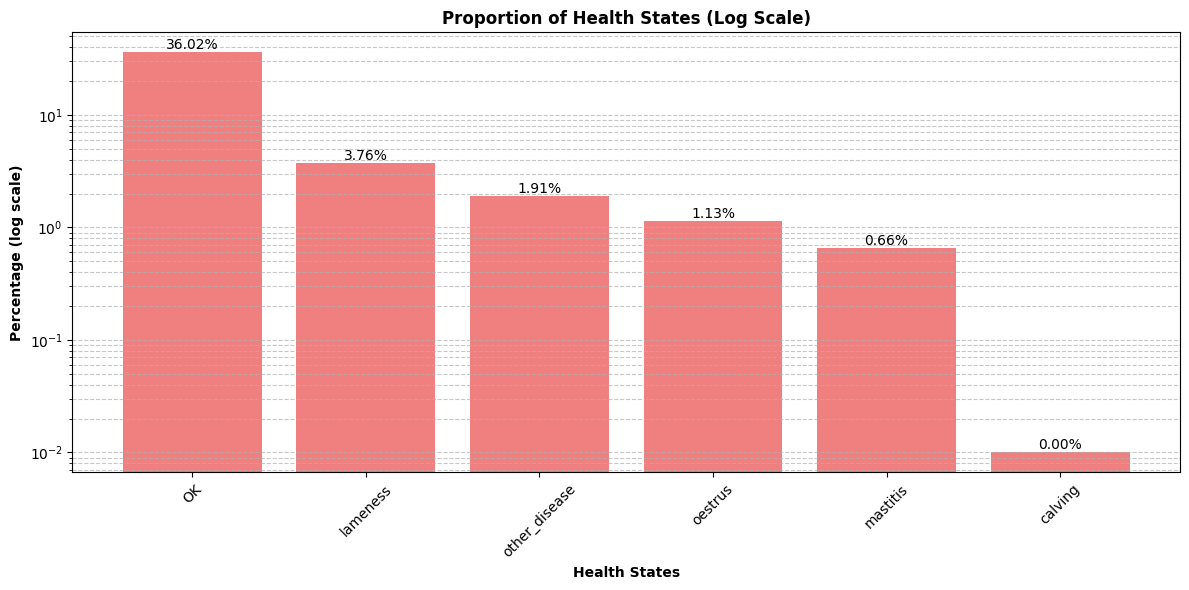

In [ ]:
health_states = ['oestrus', 'calving', 'lameness', 'mastitis', 'other_disease', 'OK']

df_health = df[health_states]
health_counts = df_health.sum().sort_values(ascending=False)
total = len(df)
health_percent = (health_counts / total) * 100

safe_health_percent = health_percent.copy()
safe_health_percent[safe_health_percent == 0] = 0.01

plt.figure(figsize=(12, 6))
bars = plt.bar(safe_health_percent.index, safe_health_percent.values, color='lightcoral')

for i, bar in enumerate(bars):
    original = health_percent.values[i]
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
             f'{original:.2f}%', ha='center', va='bottom')

plt.yscale('log')
plt.title('Proportion of Health States (Log Scale)', fontweight='bold')
plt.xlabel('Health States', fontweight='bold')
plt.ylabel('Percentage (log scale)', fontweight='bold')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7, which='both')
plt.tight_layout()
plt.show()

# one hour shifting process

In [ ]:
# Parameters
window_size_hours = 24
min_valid_hours = 18
shift_hours = 1
condition_columns = ['oestrus', 'calving', 'lameness', 'mastitis', 'other_disease']

# Adjust hour 24 to 00 and increment the date
df['adjusted_date'] = df['date']
df['adjusted_hour'] = df['hour']
df.loc[df['hour'] == 24, 'adjusted_date'] = pd.to_datetime(df.loc[df['hour'] == 24, 'date']) + timedelta(days=1)
df.loc[df['hour'] == 24, 'adjusted_hour'] = 0

# Ensure datetime format
df['adjusted_date'] = pd.to_datetime(df['adjusted_date'])

# Combine adjusted_date and adjusted_hour into a timestamp
df['timestamp'] = pd.to_datetime(df['adjusted_date'].dt.strftime('%Y-%m-%d') + ' ' + df['adjusted_hour'].astype(str) + ':00:00')
df = df.sort_values(['cow', 'timestamp'])

# Group by cow
grouped = df.groupby('cow')
shifted_windows = []

for cow_id, group in grouped:
    timestamps = group['timestamp'].tolist()
    group = group.set_index('timestamp')  # Index by timestamp for easy lookup

    print(f"\n🐄 Processing cow {cow_id} with {len(timestamps)} records...")

    for start_time in timestamps:
        end_time = start_time + timedelta(hours=window_size_hours)
        collected_hours = []
        current_time = start_time
        previous_date = current_time.date()

        while current_time < end_time:
            if current_time in group.index:
                current_date = current_time.date()

                # Stop if there's a day gap
                if (current_date - previous_date).days > 1:
                    print(f"🛑 Stopping at {current_time} due to missing day.")
                    break

                collected_hours.append(group.loc[current_time]['ACTIVITY_LEVEL'])
                previous_date = current_date
                current_time += timedelta(hours=1)
            else:
                # Hour is missing, skip it but advance time
                print(f"⚠️  Missing hour at {current_time}, skipping.")
                current_date = current_time.date()

                if (current_date - previous_date).days > 0:
                    print(f"🛑 Stopping at {current_time} due to day gap after missing hour.")
                    break

                previous_date = current_date
                current_time += timedelta(hours=1)

        if len(collected_hours) >= min_valid_hours:
            end_effective = start_time + timedelta(hours=len(collected_hours) - 1)

            # Get condition values across the window
            condition_window = group.loc[start_time:end_effective]
            condition_counts = condition_window[condition_columns].sum()

            # Prepare final label dictionary: all 0s initially
            final_conditions = {col: 0 for col in condition_columns}

            if (condition_counts > 0).any():
                most_frequent_condition = condition_counts.idxmax()
                final_conditions[most_frequent_condition] = 1
                final_conditions['OK'] = 0
            else:
                final_conditions['OK'] = 1


            shifted_windows.append({
                'cow': cow_id,
                'start_time': start_time,
                'end_time': end_effective,
                'duration_hours': len(collected_hours),
                'activity_window': collected_hours,
                **final_conditions
            })

            print(f"✅ Window for cow {cow_id} → {most_frequent_condition if (condition_counts > 0).any() else 'healthy'}")
        else:
            print(f"❌ Discarded window for cow {cow_id} from {start_time}: only {len(collected_hours)} valid hours.")

# Final DataFrame
shifted_df = pd.DataFrame(shifted_windows)

print("\n✅ DONE.")
print(f"Total valid windows collected: {len(shifted_df)}")
display(shifted_df.head())


🐄 Processing cow 151 with 1440 records...
✅ Window for cow 151 → healthy
✅ Window for cow 151 → healthy
✅ Window for cow 151 → healthy
✅ Window for cow 151 → healthy
✅ Window for cow 151 → healthy
✅ Window for cow 151 → healthy
✅ Window for cow 151 → healthy
✅ Window for cow 151 → healthy
✅ Window for cow 151 → healthy
✅ Window for cow 151 → healthy
✅ Window for cow 151 → healthy
✅ Window for cow 151 → healthy
✅ Window for cow 151 → healthy
✅ Window for cow 151 → healthy
✅ Window for cow 151 → healthy
✅ Window for cow 151 → healthy
✅ Window for cow 151 → healthy
✅ Window for cow 151 → healthy
✅ Window for cow 151 → healthy
✅ Window for cow 151 → healthy
✅ Window for cow 151 → healthy
✅ Window for cow 151 → healthy
✅ Window for cow 151 → healthy
✅ Window for cow 151 → healthy
✅ Window for cow 151 → healthy
✅ Window for cow 151 → healthy
✅ Window for cow 151 → healthy
✅ Window for cow 151 → healthy
✅ Window for cow 151 → healthy
✅ Window for cow 151 → healthy
✅ Window for cow 151 → heal

,cow,start_time,end_time,duration_hours,activity_window,oestrus,calving,lameness,mastitis,other_disease,OK
0,151,2015-03-02 01:00:00,2015-03-03 00:00:00,24,"[-640.89462, -817.46938, -821.62874, -337.2486...",0,0,0,0,0,1
1,151,2015-03-02 02:00:00,2015-03-03 01:00:00,24,"[-817.46938, -821.62874, -337.24867, -543.6490...",0,0,0,0,0,1
2,151,2015-03-02 03:00:00,2015-03-03 02:00:00,24,"[-821.62874, -337.24867, -543.64907, 779.16592...",0,0,0,0,0,1
3,151,2015-03-02 04:00:00,2015-03-03 03:00:00,24,"[-337.24867, -543.64907, 779.16592, 1460.65868...",0,0,0,0,0,1
4,151,2015-03-02 05:00:00,2015-03-03 04:00:00,24,"[-543.64907, 779.16592, 1460.65868, 947.09446,...",0,0,0,0,0,1


In [ ]:
output_csv_path = "OneHourShift.csv"
shifted_df.to_csv(output_csv_path, index=False)
print(f"CSV file saved to {output_csv_path}")

CSV file saved to OneHourShift.csv


# New dataset with one hour shift and the new 32 features

In [ ]:
# ----------------------------
# 1. Feature Calculation Logic
# ----------------------------

def calculate_all_features(activity_windows):
    features = []

    for window in activity_windows:
        try:
            window = np.array(window)
            feature_dict = {}

            # Time-Domain Features (1–17)
            feature_dict['Minimum'] = np.min(window)
            feature_dict['Maximum'] = np.max(window)
            feature_dict['Mean'] = np.mean(window)
            feature_dict['RMS'] = np.sqrt(np.mean(np.square(window)))
            feature_dict['STD'] = np.std(window)

            # 6-hour windows
            six_h_windows = [window[i*6:(i+1)*6] for i in range(4)]
            stds_6h = [np.std(w) for w in six_h_windows]
            means_6h = [np.mean(w) for w in six_h_windows]
            feature_dict['MeanSTD6h'] = np.mean(stds_6h)
            feature_dict['STDMean6h'] = np.std(means_6h)

            diffs = np.diff(window)
            feature_dict['STDSD'] = np.std(diffs)


            # RMSSD (successive differences)
            feature_dict['RMSSD'] = np.sqrt(np.mean(np.square(diffs)))

            # Distribution features
            feature_dict['Mode'] = stats.mode(window, keepdims=True)[0][0] if len(window) > 0 else np.nan
            feature_dict['Q10'] = np.percentile(window, 10)
            feature_dict['Q90'] = np.percentile(window, 90)
            feature_dict['Q25'] = np.percentile(window, 25)
            feature_dict['Q50'] = np.percentile(window, 50)
            feature_dict['Q75'] = np.percentile(window, 75)
            feature_dict['Skewness'] = stats.skew(window)
            feature_dict['Kurtosis'] = stats.kurtosis(window)

            # Autocorrelation (lags 1 to 11)
            for lag in range(1, 12):
                if len(window) > lag:
                    corr = np.corrcoef(window[:-lag], window[lag:])[0, 1]
                else:
                    corr = np.nan
                feature_dict[f'Autocorr{lag}'] = corr

            # Frequency-Domain Features (harmonics)
            fft_result = np.abs(fft.fft(window))
            harmonics = fft_result[1:5]
            for i, h in enumerate(harmonics, 1):
                feature_dict[f'h{i}'] = h

            features.append(feature_dict)

        except Exception as e:
            print(f"Error processing window: {e}")
            features.append({f: np.nan for f in FEATURE_NAMES})

    return pd.DataFrame(features)

# Feature name list (same order as above)
FEATURE_NAMES = [
    'Minimum', 'Maximum', 'Mean', 'RMS', 'STD',
    'MeanSTD6h', 'STDMean6h', 'STDSD', 'RMSSD', 'Mode',
    'Q10', 'Q90', 'Q25', 'Q50', 'Q75',
    'Skewness', 'Kurtosis',
    *[f'Autocorr{i}' for i in range(1, 12)],
    *[f'h{i}' for i in range(1, 5)]
]

# ----------------------------
# 2. Apply Feature Extraction
# ----------------------------

features_df = calculate_all_features(shifted_df['activity_window'])



c:\Users\ghozz\anaconda3\envs\tensorflow\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\ghozz\anaconda3\envs\tensorflow\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\ghozz\anaconda3\envs\tensorflow\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\ghozz\anaconda3\envs\tensorflow\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ghozz\anaconda3\envs\tensorflow\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
shifted_df.columns

Index(['cow', 'start_time', 'end_time', 'duration_hours', 'activity_window',
       'oestrus', 'calving', 'lameness', 'mastitis', 'other_disease', 'OK'],
      dtype='object')

In [ ]:
# ----------------------------
# 3. Combine with Original Data
# ----------------------------

shifted_df_cleaned = shifted_df.drop(columns=['activity_window'])
features_columns = ['cow', 'start_time', 'end_time', 'duration_hours']
label_columns = [col for col in shifted_df_cleaned.columns if col not in features_columns]

final_df = pd.concat([
    shifted_df_cleaned[features_columns],
    features_df[FEATURE_NAMES],
    shifted_df_cleaned[label_columns]
], axis=1)

# ----------------------------
# 4. Save and Display
# ----------------------------

output_path = "32features_1hour_shift_1.csv"
final_df.to_csv(output_path, index=False)

print(f"\n✅ Processing complete! Results saved to {output_path}")
print(f"📊 Final dataset shape: {final_df.shape}")
print("\n🔍 First 3 rows of the final dataset:")
display(final_df.head(3))


✅ Processing complete! Results saved to 32features_1hour_shift_1.csv
📊 Final dataset shape: (39754, 42)

🔍 First 3 rows of the final dataset:


,cow,start_time,end_time,duration_hours,Minimum,Maximum,Mean,RMS,STD,MeanSTD6h,...,h1,h2,h3,h4,oestrus,calving,lameness,mastitis,other_disease,OK
0,151,2015-03-02 01:00:00,2015-03-03 00:00:00,24,-821.62874,1471.43776,266.806858,909.703731,869.698211,582.102664,...,9054.881839,2749.134118,5402.793031,5328.034727,0,0,0,0,0,1
1,151,2015-03-02 02:00:00,2015-03-03 01:00:00,24,-821.62874,1471.43776,260.727509,914.461769,876.505272,688.865117,...,9200.190073,2875.733548,5292.373492,5310.124693,0,0,0,0,0,1
2,151,2015-03-02 03:00:00,2015-03-03 02:00:00,24,-821.62874,1471.43776,260.574873,914.598511,876.693317,746.260210,...,9203.629436,2877.617696,5292.140348,5313.078588,0,0,0,0,0,1


In [ ]:
display(final_df.head(24))


,cow,start_time,end_time,duration_hours,Minimum,Maximum,Mean,RMS,STD,MeanSTD6h,...,h1,h2,h3,h4,oestrus,calving,lameness,mastitis,other_disease,OK
0,151,2015-03-02 01:00:00,2015-03-03 00:00:00,24,-821.62874,1471.43776,266.806858,909.703731,869.698211,582.102664,...,9054.881839,2749.134118,5402.793031,5328.034727,0,0,0,0,0,1
1,151,2015-03-02 02:00:00,2015-03-03 01:00:00,24,-821.62874,1471.43776,260.727509,914.461769,876.505272,688.865117,...,9200.190073,2875.733548,5292.373492,5310.124693,0,0,0,0,0,1
2,151,2015-03-02 03:00:00,2015-03-03 02:00:00,24,-821.62874,1471.43776,260.574873,914.598511,876.693317,746.260210,...,9203.629436,2877.617696,5292.140348,5313.078588,0,0,0,0,0,1
3,151,2015-03-02 04:00:00,2015-03-03 03:00:00,24,-821.13265,1471.43776,262.275842,913.107192,874.629137,729.288874,...,9170.273156,2877.205955,5265.248174,5275.739072,0,0,0,0,0,1
4,151,2015-03-02 05:00:00,2015-03-03 04:00:00,24,-827.99977,1471.43776,241.827879,926.062472,893.930075,732.949766,...,9491.396989,2667.298899,5754.926014,5349.922811,0,0,0,0,0,1
5,151,2015-03-02 06:00:00,2015-03-03 05:00:00,24,-827.99977,1471.43776,231.884563,933.153749,903.883548,640.289696,...,9602.092796,2487.385133,5936.096960,5173.045504,0,0,0,0,0,1
6,151,2015-03-02 07:00:00,2015-03-03 06:00:00,24,-827.99977,1471.43776,233.088141,934.176781,904.630409,594.098979,...,9595.503918,2515.556461,5933.575014,5200.682914,0,0,0,0,0,1
7,151,2015-03-02 08:00:00,2015-03-03 07:00:00,24,-827.99977,1471.43776,218.765402,914.203682,887.642987,682.144507,...,9590.270481,2189.753674,5718.064976,5133.466697,0,0,0,0,0,1
8,151,2015-03-02 09:00:00,2015-03-03 08:00:00,24,-827.99977,1471.43776,144.999946,909.194634,897.557741,742.649737,...,9295.548347,1715.586493,3969.596025,6597.874933,0,0,0,0,0,1
9,151,2015-03-02 10:00:00,2015-03-03 09:00:00,24,-827.99977,1471.43776,179.451341,903.354889,885.351496,731.060344,...,9599.769253,1312.119233,4676.902163,5899.619695,0,0,0,0,0,1


# Method one RF

In [ ]:
df_32 = pd.read_csv(r"32features_1hour_shift_1.csv")

# ----------------------------
# Step 1: Convert multi-label to single class
# ----------------------------

def get_target_label(row):
    for label in ['oestrus', 'calving', 'lameness', 'mastitis', 'other_disease']:
        if row[label] == 1:
            return label
    return 'OK'  # No disease -> healthy cow

df_32['target'] = df_32.apply(get_target_label, axis=1)

feature_cols = [
    'Minimum', 'Maximum', 'Mean', 'RMS', 'STD', 'MeanSTD6h', 'STDMean6h', 'STDSD',
    'RMSSD', 'Mode', 'Q10', 'Q90', 'Q25', 'Q50', 'Q75',
    'Skewness', 'Kurtosis'
] + [f'Autocorr{i}' for i in range(1, 12)] + [f'h{i}' for i in range(1, 5)]

# ----------------------------
# Step 2: Prepare Features and Target
# ----------------------------

X = df_32[feature_cols]
y = df_32['target']

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# ----------------------------
# Step 3: Train Random Forest
# ----------------------------

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# ----------------------------
# Step 4: Feature Importance
# ----------------------------

importances = clf.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Filter features with importance greater than 2.4%
selected_features_df = feature_importance_df[feature_importance_df['Importance'] > 0.024]

# Display the number of selected features and their importance
print(f"Number of features selected (importance > 2.4%): {len(selected_features_df)}")
print(selected_features_df[['Feature', 'Importance']].to_string(index=False))

Number of features selected (importance > 2.4%): 23
  Feature  Importance
  Maximum    0.061136
      Q90    0.049792
      Q75    0.048030
 Kurtosis    0.046142
      Q50    0.045248
     Mean    0.044900
      Q25    0.044298
 Skewness    0.043234
      Q10    0.040718
       h1    0.035792
       h4    0.034149
       h3    0.032611
       h2    0.032186
    STDSD    0.028712
      STD    0.028557
Autocorr2    0.028348
    RMSSD    0.027833
Autocorr1    0.027191
      RMS    0.027070
     Mode    0.025681
Autocorr3    0.025031
  Minimum    0.024663
Autocorr5    0.024344


### second round

In [ ]:
from sklearn.metrics import classification_report, f1_score

# Extract features with importance > 2.4%
selected_features = feature_importance_df[feature_importance_df['Importance'] > 0.024]['Feature'].tolist()

# Prepare the new data with selected features
X_selected = df_32[selected_features]

# New train/test split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# New Random Forest model
clf2 = RandomForestClassifier(n_estimators=100, random_state=42)
clf2.fit(X_train2, y_train2)

# Evaluate the performance
accuracy = clf2.score(X_test2, y_test2)
print(f"\nAccuracy with Selected Features (importance > 2.4%): {accuracy:.4f}")

# Predictions
y_pred2 = clf2.predict(X_test2)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test2, y_pred2))

# F1 Scores
f1_macro = f1_score(y_test2, y_pred2, average='macro')
f1_weighted = f1_score(y_test2, y_pred2, average='weighted')
print(f"F1 Macro: {f1_macro:.4f}")
print(f"F1 Weighted: {f1_weighted:.4f}")

# ----------------------------
# Feature Importance Plot
# ----------------------------

# Get importances again but only for selected features
importances_selected = clf2.feature_importances_


# Create a DataFrame for visualization
selected_importance_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': importances_selected
}).sort_values(by='Importance', ascending=False)

print("\nImportance of selected features :")
print(selected_importance_df.to_string(index=False))



Accuracy with Selected Features (importance > 2.4%): 0.9712

Classification Report:
               precision    recall  f1-score   support

           OK       0.97      1.00      0.98      7283
     lameness       0.97      0.72      0.83       333
     mastitis       0.93      0.77      0.84        48
      oestrus       1.00      0.53      0.69       102
other_disease       1.00      0.63      0.77       185

     accuracy                           0.97      7951
    macro avg       0.97      0.73      0.82      7951
 weighted avg       0.97      0.97      0.97      7951

F1 Macro: 0.8236
F1 Weighted: 0.9685

Importance of selected features :
  Feature  Importance
  Maximum    0.072019
      Q75    0.061516
      Q90    0.058748
      Q50    0.055001
 Kurtosis    0.052603
 Skewness    0.050808
      Q25    0.050668
     Mean    0.048479
      Q10    0.048324
       h3    0.044532
       h1    0.043714
       h4    0.041380
       h2    0.040647
    RMSSD    0.035783
Autocorr2    0.

In [ ]:
len(selected_importance_df)

23

# Shapley values

## Étape 1 : Entraîner un modèle XGBoost avec toutes les features

In [ ]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
import xgboost as xgb

# Features et labels
X = final_df[feature_cols]
label = ['oestrus', 'lameness', 'mastitis', 'other_disease']
y = final_df[label]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modèle multilabel via MultiOutputClassifier
base_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
multi_model = MultiOutputClassifier(base_model)
multi_model.fit(X_train, y_train)


c:\Users\ghozz\anaconda3\envs\tensorflow\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:53:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\ghozz\anaconda3\envs\tensorflow\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:53:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\ghozz\anaconda3\envs\tensorflow\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:53:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\ghozz\anaconda3\envs\tensorflow\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:53:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Par

MultiOutputClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='logloss',
                                              feature_types=None,
                                              feature_weights=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None, ...))

## Étape 2 : Calculer les SHAP values

Traitement de la condition: oestrus
Traitement de la condition: lameness
Traitement de la condition: mastitis
Traitement de la condition: other_disease


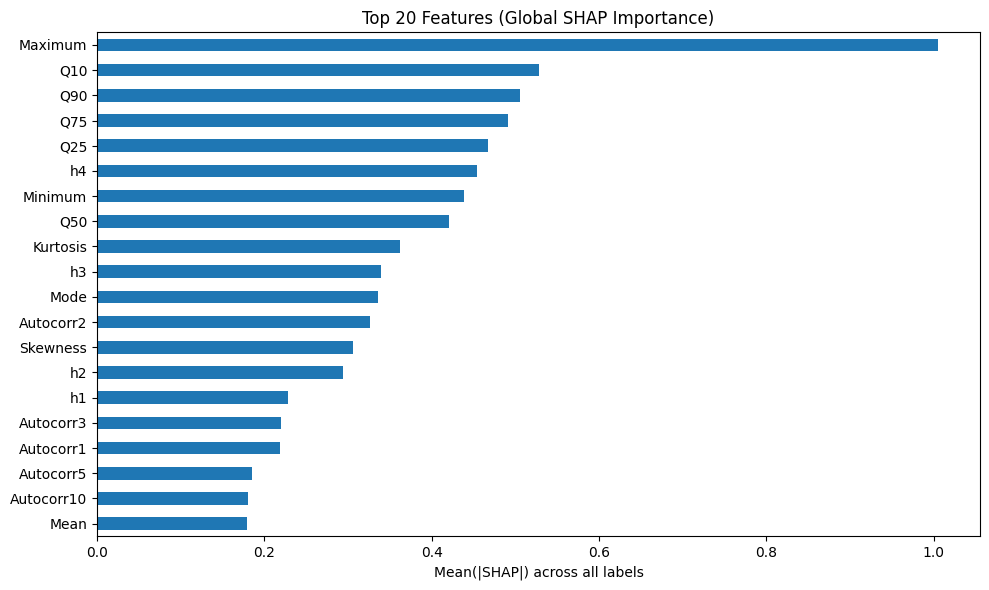

,oestrus,lameness,mastitis,other_disease,mean_global
Maximum,1.099017,0.711758,1.303032,0.907416,1.005306
Q10,0.428168,0.332831,0.787680,0.563107,0.527947
Q90,0.576586,0.387418,0.471660,0.585589,0.505313
Q75,0.565136,0.365205,0.707533,0.325475,0.490837
Q25,0.433503,0.352682,0.755300,0.329212,0.467674
h4,0.265991,0.357288,0.870584,0.322020,0.453971
Minimum,0.398984,0.417439,0.290657,0.649401,0.439120
Q50,0.340746,0.365194,0.558244,0.420449,0.421158
Kurtosis,0.360223,0.543616,0.216830,0.329041,0.362427
h3,0.168884,0.298642,0.556522,0.331914,0.338991


In [ ]:
import shap
import numpy as np

# Stockage des SHAP moyens pour chaque feature par label
shap_matrix = pd.DataFrame(index=X_test.columns)

# Boucle sur chaque label
for i, target in enumerate(label):
    print(f"Traitement de la condition: {target}")

    single_model = multi_model.estimators_[i]
    explainer = shap.Explainer(single_model)
    shap_values = explainer(X_test)

    mean_shap = np.abs(shap_values.values).mean(axis=0)

    # Ajouter les valeurs dans la matrice
    shap_matrix[target] = mean_shap

# Moyenne globale des SHAP values par feature
shap_matrix['mean_global'] = shap_matrix.mean(axis=1)

# Tri des features par importance globale
shap_ranked = shap_matrix.sort_values('mean_global', ascending=False)

# Affichage du top 20
top_features = shap_ranked.head(20)

# Visualisation
plt.figure(figsize=(10, 6))
top_features['mean_global'].plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Top 20 Features (Global SHAP Importance)")
plt.xlabel("Mean(|SHAP|) across all labels")
plt.tight_layout()
plt.show()

display(top_features)


## Étape 3 : Sélectionner les features importantes with grid search to identify the threshold

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier

import numpy as np
import pandas as pd

# Train-test split (refait pour clarté)
X = final_df[feature_cols]
y = final_df[label]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Étape 1: Entraîner le modèle initial pour obtenir les SHAP values
base_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
multi_model = MultiOutputClassifier(base_model)
multi_model.fit(X_train, y_train)

# Calcul des SHAP moyens globaux
shap_matrix = pd.DataFrame(index=X_test.columns)

for i, target in enumerate(label):
    explainer = shap.Explainer(multi_model.estimators_[i])
    shap_values = explainer(X_test)
    mean_shap = np.abs(shap_values.values).mean(axis=0)
    shap_matrix[target] = mean_shap

shap_matrix['mean_global'] = shap_matrix.mean(axis=1)

# Étape 2: Essai de plusieurs seuils pour la sélection de features
thresholds = np.arange(0.05, 0.3, 0.02)
results = []

for threshold in thresholds:
    selected_features = shap_matrix[shap_matrix['mean_global'] >= threshold].index.tolist()

    if not selected_features:
        print(f"🔴 Seuil {threshold}: aucune feature sélectionnée.")
        continue

    X_train_sel = X_train[selected_features]
    X_test_sel = X_test[selected_features]

    model_sel = MultiOutputClassifier(xgb.XGBClassifier(eval_metric='logloss'))
    model_sel.fit(X_train_sel, y_train)

    y_pred = model_sel.predict(X_test_sel)

    # Évaluation multilabel
    f1 = np.mean([f1_score(y_test.iloc[:, i], y_pred[:, i], zero_division=0, average='macro') for i in range(y.shape[1])])
    precision = np.mean([precision_score(y_test.iloc[:, i], y_pred[:, i], zero_division=0) for i in range(y.shape[1])])
    recall = np.mean([recall_score(y_test.iloc[:, i], y_pred[:, i], zero_division=0) for i in range(y.shape[1])])

    # Gestion AUC (nécessite predict_proba et au moins deux classes présentes)
    try:
        y_prob = np.column_stack([model_sel.estimators_[i].predict_proba(X_test_sel)[:, 1] for i in range(y.shape[1])])
        auc = np.mean([roc_auc_score(y_test.iloc[:, i], y_prob[:, i]) for i in range(y.shape[1])])
    except Exception as e:
        auc = np.nan

    print(f"✅ Seuil {threshold:.3f} | {len(selected_features)} features | F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | AUC: {auc:.4f}")

    results.append({
        'threshold': threshold,
        'num_features': len(selected_features),
        'f1_macro': f1,
        'precision_macro': precision,
        'recall_macro': recall,
        'roc_auc_macro': auc
    })

# Résumé
results_df = pd.DataFrame(results)
display(results_df.sort_values(by='f1_macro', ascending=False))

c:\Users\ghozz\anaconda3\envs\tensorflow\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:53:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\ghozz\anaconda3\envs\tensorflow\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:53:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\ghozz\anaconda3\envs\tensorflow\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:53:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\ghozz\anaconda3\envs\tensorflow\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:53:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Par

✅ Seuil 0.050 | 32 features | F1: 0.9466 | Precision: 0.9667 | Recall: 0.8341 | AUC: 0.9967
✅ Seuil 0.070 | 31 features | F1: 0.9446 | Precision: 0.9555 | Recall: 0.8361 | AUC: 0.9972
✅ Seuil 0.090 | 31 features | F1: 0.9446 | Precision: 0.9555 | Recall: 0.8361 | AUC: 0.9972
✅ Seuil 0.110 | 30 features | F1: 0.9468 | Precision: 0.9587 | Recall: 0.8409 | AUC: 0.9983
✅ Seuil 0.130 | 27 features | F1: 0.9484 | Precision: 0.9516 | Recall: 0.8521 | AUC: 0.9983
✅ Seuil 0.150 | 23 features | F1: 0.9502 | Precision: 0.9635 | Recall: 0.8491 | AUC: 0.9990
✅ Seuil 0.170 | 22 features | F1: 0.9426 | Precision: 0.9520 | Recall: 0.8329 | AUC: 0.9990
✅ Seuil 0.190 | 17 features | F1: 0.9526 | Precision: 0.9586 | Recall: 0.8612 | AUC: 0.9986
✅ Seuil 0.210 | 17 features | F1: 0.9526 | Precision: 0.9586 | Recall: 0.8612 | AUC: 0.9986
✅ Seuil 0.230 | 14 features | F1: 0.9544 | Precision: 0.9666 | Recall: 0.8621 | AUC: 0.9981
✅ Seuil 0.250 | 14 features | F1: 0.9544 | Precision: 0.9666 | Recall: 0.8621 | 

,threshold,num_features,f1_macro,precision_macro,recall_macro,roc_auc_macro
9,0.23,14,0.954424,0.966612,0.862123,0.998080
10,0.25,14,0.954424,0.966612,0.862123,0.998080
11,0.27,14,0.954424,0.966612,0.862123,0.998080
12,0.29,14,0.954424,0.966612,0.862123,0.998080
7,0.19,17,0.952561,0.958574,0.861214,0.998559
8,0.21,17,0.952561,0.958574,0.861214,0.998559
5,0.15,23,0.950244,0.963512,0.849105,0.998962
4,0.13,27,0.948402,0.951577,0.852054,0.998324
3,0.11,30,0.946756,0.958748,0.840900,0.998349
0,0.05,32,0.946571,0.966659,0.834089,0.996717


### Optimal :Seuil 0.210 | 24 features | F1: 0.7872 | Precision: 0.9710 | Recall: 0.6714 | AUC: 0.9976

In [ ]:
threshold = 0.170
selected_features = shap_matrix[shap_matrix['mean_global'] >= threshold].index.tolist()

print(f"🎯 Seuil choisi = {threshold}")
print(f"✅ {len(selected_features)} features sélectionnées :\n{selected_features}")

🎯 Seuil choisi = 0.17
✅ 22 features sélectionnées :
['Minimum', 'Maximum', 'Mean', 'RMS', 'Mode', 'Q10', 'Q90', 'Q25', 'Q50', 'Q75', 'Skewness', 'Kurtosis', 'Autocorr1', 'Autocorr2', 'Autocorr3', 'Autocorr4', 'Autocorr5', 'Autocorr10', 'h1', 'h2', 'h3', 'h4']


# SV-RF

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
import pandas as pd

# Features and labels
X = final_df[feature_cols]
y = final_df[['oestrus', 'lameness', 'mastitis', 'other_disease']]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Multi-label classification with RF
base_model = RandomForestClassifier(n_estimators=100, random_state=42)
multi_model = MultiOutputClassifier(base_model)
multi_model.fit(X_train, y_train)


MultiOutputClassifier(estimator=RandomForestClassifier(random_state=42))

Traitement de la condition: oestrus


100%|===================| 15843/15902 [03:36<00:00]        

Traitement de la condition: lameness


100%|===================| 15892/15902 [05:44<00:00]        

Traitement de la condition: mastitis


 99%|===================| 15768/15902 [01:27<00:00]        

Traitement de la condition: other_disease


100%|===================| 15897/15902 [04:09<00:00]        

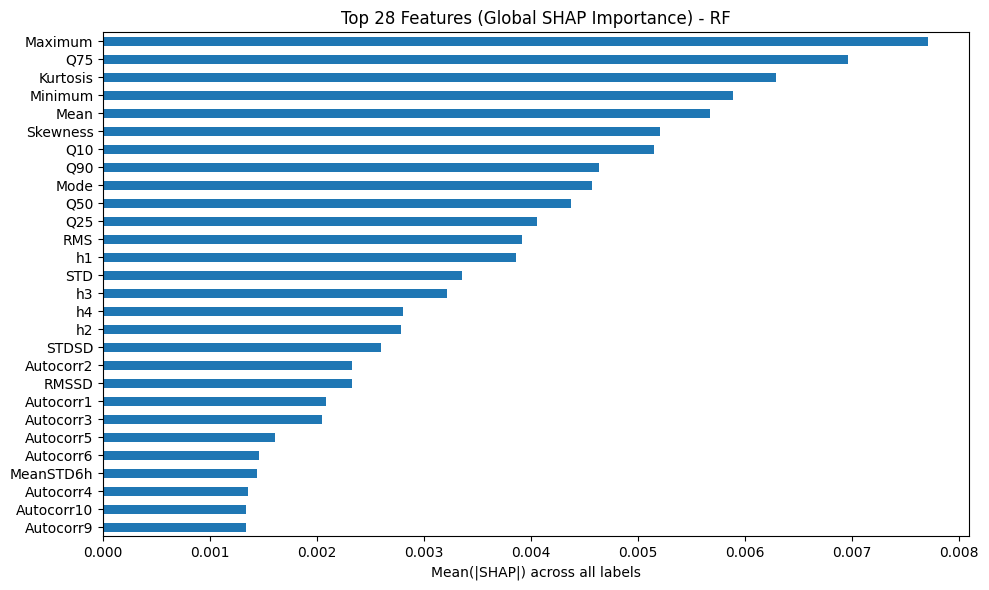

,oestrus,lameness,mastitis,other_disease,mean_global
Maximum,0.013322,0.004352,0.005616,0.007527,0.007704
Q75,0.007123,0.007539,0.006166,0.006999,0.006957
Kurtosis,0.004791,0.014683,0.002121,0.003549,0.006286
Minimum,0.003499,0.006684,0.007907,0.005464,0.005889
Mean,0.002945,0.006684,0.001279,0.011778,0.005671
Skewness,0.005327,0.010038,0.002259,0.003178,0.005200
Q10,0.002733,0.004759,0.005235,0.007846,0.005143
Q90,0.004087,0.006101,0.002765,0.005562,0.004629
Mode,0.003682,0.005979,0.004789,0.003825,0.004569
Q50,0.003753,0.005839,0.004271,0.003635,0.004375


In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# SHAP values storage
shap_matrix = pd.DataFrame(index=X_test.columns)

# Loop over each label
for i, target in enumerate(y.columns):
    print(f"Traitement de la condition: {target}")

    single_model = multi_model.estimators_[i]
    explainer = shap.Explainer(single_model, X_test)  # TreeExplainer auto-select
    shap_values = explainer(X_test)

    # Keep only SHAP values for class 1 (positive class)
    mean_shap = np.abs(shap_values.values[:, :, 1]).mean(axis=0)
    shap_matrix[target] = mean_shap

# Mean global SHAP per feature
shap_matrix['mean_global'] = shap_matrix.mean(axis=1)
shap_ranked = shap_matrix.sort_values('mean_global', ascending=False)

# Plot top 28
top_features = shap_ranked.head(28)
plt.figure(figsize=(10, 6))
top_features['mean_global'].plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Top 28 Features (Global SHAP Importance) - RF")
plt.xlabel("Mean(|SHAP|) across all labels")
plt.tight_layout()
plt.show()

display(top_features)


In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score

thresholds = np.arange(0.05, 0.3, 0.02)
results = []

for threshold in thresholds:
    selected_features = shap_matrix[shap_matrix['mean_global'] >= threshold].index.tolist()

    if not selected_features:
        print(f"🔴 Seuil {threshold}: aucune feature sélectionnée.")
        continue

    X_train_sel = X_train[selected_features]
    X_test_sel = X_test[selected_features]

    model_sel = MultiOutputClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
    model_sel.fit(X_train_sel, y_train)
    y_pred = model_sel.predict(X_test_sel)

    f1 = np.mean([f1_score(y_test.iloc[:, i], y_pred[:, i], zero_division=0, average='macro') for i in range(y.shape[1])])
    precision = np.mean([precision_score(y_test.iloc[:, i], y_pred[:, i], zero_division=0) for i in range(y.shape[1])])
    recall = np.mean([recall_score(y_test.iloc[:, i], y_pred[:, i], zero_division=0) for i in range(y.shape[1])])

    # AUC requires probabilities
    try:
        y_prob = np.column_stack([model_sel.estimators_[i].predict_proba(X_test_sel)[:, 1] for i in range(y.shape[1])])
        auc = np.mean([roc_auc_score(y_test.iloc[:, i], y_prob[:, i]) for i in range(y.shape[1])])
    except Exception as e:
        auc = np.nan

    print(f"✅ Seuil {threshold:.3f} | {len(selected_features)} features | F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | AUC: {auc:.4f}")

    results.append({
        'threshold': threshold,
        'num_features': len(selected_features),
        'f1_macro': f1,
        'precision_macro': precision,
        'recall_macro': recall,
        'roc_auc_macro': auc
    })

# Résumé
results_df = pd.DataFrame(results)
display(results_df.sort_values(by='f1_macro', ascending=False))


🔴 Seuil 0.05: aucune feature sélectionnée.
🔴 Seuil 0.07: aucune feature sélectionnée.
🔴 Seuil 0.09000000000000001: aucune feature sélectionnée.
🔴 Seuil 0.11000000000000001: aucune feature sélectionnée.
🔴 Seuil 0.13: aucune feature sélectionnée.
🔴 Seuil 0.15000000000000002: aucune feature sélectionnée.
🔴 Seuil 0.17000000000000004: aucune feature sélectionnée.
🔴 Seuil 0.19: aucune feature sélectionnée.
🔴 Seuil 0.21000000000000002: aucune feature sélectionnée.
🔴 Seuil 0.23000000000000004: aucune feature sélectionnée.
🔴 Seuil 0.25000000000000006: aucune feature sélectionnée.
🔴 Seuil 0.27: aucune feature sélectionnée.
🔴 Seuil 0.29000000000000004: aucune feature sélectionnée.


KeyError: 'f1_macro'

In [ ]:
threshold = 0.17
selected_features = shap_matrix[shap_matrix['mean_global'] >= threshold].index.tolist()

print(f"🎯 Seuil choisi = {threshold}")
print(f"✅ {len(selected_features)} features sélectionnées :\n{selected_features}")


🎯 Seuil choisi = 0.17
✅ 22 features sélectionnées :
['Minimum', 'Maximum', 'Mean', 'RMS', 'Mode', 'Q10', 'Q90', 'Q25', 'Q50', 'Q75', 'Skewness', 'Kurtosis', 'Autocorr1', 'Autocorr2', 'Autocorr3', 'Autocorr4', 'Autocorr5', 'Autocorr10', 'h1', 'h2', 'h3', 'h4']
